In [ ]:
# sentencepiece was the issue install 0.1.86
# if error occurs during training that gives a segmantion error it is most likely the sentencpice version

In [52]:
import torch
import tensorflow as tf
import sys
import ktrain
import pandas as pd
import os
import numpy as np
from collections import Counter
import os
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, confusion_matrix
from tqdm import tqdm
import nltk
import re
from enum import Enum
from sklearn.model_selection import train_test_split
import string
import matplotlib.pyplot as plt; plt.rcdefaults()
import seaborn as sns
import random
from tqdm import tqdm
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, LancasterStemmer, SnowballStemmer,WordNetLemmatizer 
import spacy
import nlpaug.augmenter.word as naw
import math
import sklearn
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
#from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from ktrain import text
config = tf.compat.v1.ConfigProto(gpu_options = 
                         tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.95)
# device_count = {'GPU': 1}
)
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(session)

In [53]:
# this shows available GPU's. If you have a NVIDIA GPU but dont see it here there is a vesioning erorr
# or cuda is missing!
# check here for more infos about compatibility between tensorflow 2, cuDNN, and cuda
# https://www.tensorflow.org/install/source#gpu
tf.config.list_physical_devices('GPU')

[]

## extraction of ID's and text from .txt transcripts, and removing metadata

In [54]:
dataPath = "./data/new/broadcast/"
allTranscrips = os.listdir(dataPath)
abrv_months = ["Apr", "May", "Jun", "Jul", "Aug",
              "Sep", "Oct", "Nov", "Dec", "Jan", 
              "Feb", "Mar"]

contents = []
id_ = []
temp = ""
new_row = 0

for month in allTranscrips:
    with open(dataPath+month, encoding="utf-8") as transcripts:
        for line in transcripts:
            check = False
            if "B_" in line:
                id_.append(line.replace("\n", ""))
                new_row = 1
                continue
            if "(CBS)" in line or "(Radio)" in line or "(NBC)" in line or "(ABC)" in line or \
                "KONG-SEA" in line or "(FOX)" in line or "FM News" in line or "News Radio" in line or \
                 "AM 860" in line or "KOBI" in line or "(PBS)" in line or "KBNZ" in line or \
                 "KNKX" in line or "Portland's CW" in line or "Fox 12 Plus" in line or \
                 "KINK Radio" in line or "OPB" in line or "Fox Sports Radio" in line:
                continue
            for i in abrv_months:
                if "AM" in line and i in line and "•" in line \
                or "PM" in line and i in line and "•" in line:
                    check = True
                    break
            if check == True:
                continue
            if len(line.strip()) < 4:
                    continue
            if new_row == 1:
                temp = temp.replace("\n", " ")
                contents.append(temp)
                temp = ""
                new_row = 34
            if new_row == 34:
                temp+=line

ser = pd.Series(contents[1:])
ser1 = pd.Series(id_)
d = {"AC01_01":ser1.str.upper(),"text":ser}
df = pd.DataFrame(data=d)
df = df[:-1]

316.0204755614267 
 944.6500000000001 
 1411.0


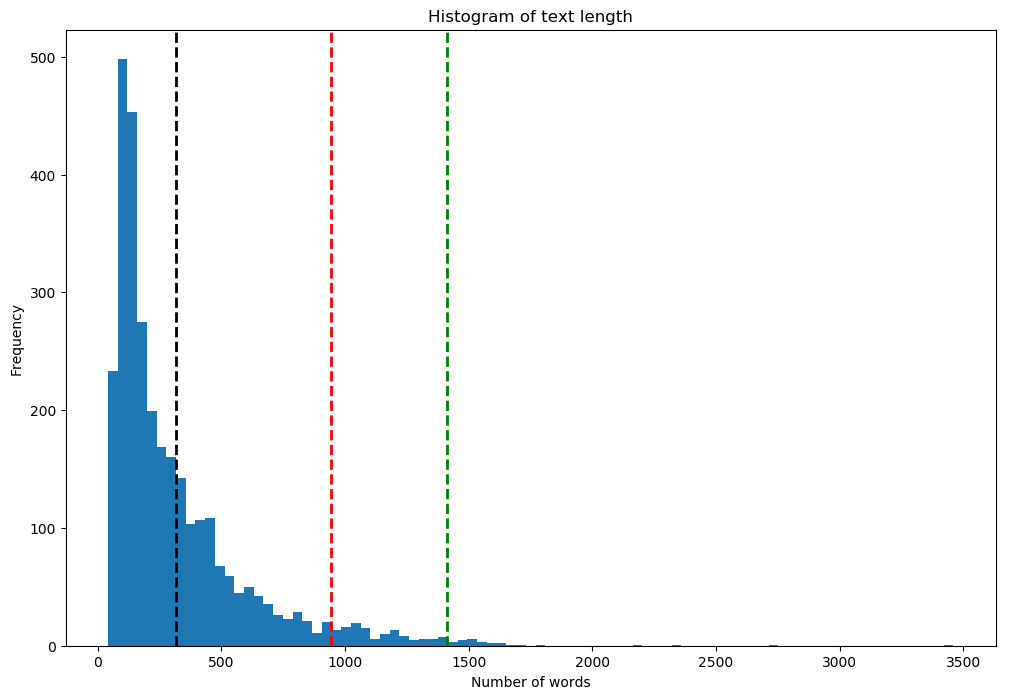

In [55]:
# sequence length histogram to determine cutoff
a = []
for i in df.text.values:
    temp = i.split(" ")
    a.append(len(temp))
    
fig, ax = plt.subplots(figsize=(12,8))

plt.hist(a, bins='auto')
plt.axvline(np.mean(a), color='k', linestyle='dashed', linewidth=2)
plt.axvline(np.percentile(a, 95), color='red', linestyle='dashed', linewidth=2)
plt.axvline(np.percentile(a, 99), color='green', linestyle='dashed', linewidth=2)
plt.xlabel('Number of words')
plt.ylabel('Frequency')
plt.title("Histogram of text length")
fig.savefig("seq_len_CI.png", dpi=600)
print(np.mean(a), "\n", np.percentile(a, 95), "\n", np.percentile(a, 99) )

In [56]:
df.shape

(3028, 2)

In [57]:
# add here the latest Excel with the manually coded variable codes
f = "./data/new/V!brant_data_all_161220.xlsx"
df_classes = pd.read_excel(f)

In [58]:
df_classes = df_classes.iloc[1:]

# Selecting a variable code and filtering for coder -9

In [59]:
# class that maps the name to its variable code
class VariableCodes(Enum):
    COMPLETED_SUICIDE = "MF02_01"
    CELEBRITY_SUICIDE = "ID05_01"
    SUICIDAL_IDEATION = "MF02_03"
    ALTERNATIVES_TO_SUICIDE = "AU01_01"
    MONOCAUSALITY = "CS02_01"
    HEALING_STORY = "MF02_12"
    POSITIVE_OUTCOME_CRISIS = "PO01_01"
    ENHANCING_MYTHS = "PR01_01"
    PROBLEM_SOLUTION = "PS01"
    MAIN_FOCUS = "MF01"

In [68]:
# select variable code
variableCode = VariableCodes.ALTERNATIVES_TO_SUICIDE.value
# upper case ID for Excel and extracted ID's to match
df_classes.AC01_01 = df_classes.AC01_01.str.upper()
# combine extracted text and variable codes from excel, by joining on ID
fin = pd.merge(df, df_classes, on="AC01_01")
print("joined", fin.shape)
# select revelant columns
df_var = fin.filter(items=["AC01_01", "text", variableCode, "CO01"])
# filter for coder -9 for consistently labeled training data
df_var = df_var[df_var["CO01"]==-9]
# remove texts that dont have a assigned number (-9)
df_var = df_var[df_var[variableCode]!=-9]
print("only coder -9", df_var.shape)
print(Counter(df_var[variableCode]).most_common())

joined (2936, 158)
only coder -9 (2379, 4)
[(1, 1970), (2, 409)]


In [69]:
word_len = [len(text.split(" ")) for text in df_var.text.values]
longer = 0
for len_ in word_len:
    if len_ > 512:
        longer += 1
print( longer, longer / df_var.shape[0])


391 0.16435477091214795


# variableCode specific remapping 
 
This code chunk remaps the numbers to their associated textual decriptions based on the coding scheme PDF. You have to do this manaully for every variable code (if it is NOT binary). For binary you can always use the binary template :)

In [70]:
#df_var[variableCode] = df_var[variableCode].replace(1,"Problem").replace(2,"Solution").replace(3, "Both").replace(4, "Neither")
df_var[variableCode] = df_var[variableCode].replace(1,"no").replace(2,"yes")
"""
df_var[variableCode] = df_var[variableCode].replace(1,"completed").replace(2,"attempted"). \
    replace(3,"ideation").replace(4,"mur_sui_indi").replace(5,"mass_mur_sui"). \
    replace(6,"assisted").replace(7,"cluster").replace(9,"policy_pvt").replace(10,"research"). \
    replace(11,"legal_issues").replace(12,"healing_story").replace(13,"other").replace(14,"advocacy").\
    replace(15,"prevention")
"""
df_var

,AC01_01,text,AU01_01,CO01
0,B_APR_WASH_1,Action News introduced you to a retired vetera...,no,-9
4,B_APR_OREG_2,the harmony for Spain is set to go to the poll...,no,-9
6,B_APR_WASH_3,A recently retired army veteran is walking acr...,no,-9
8,B_APR_WASH_4,a recently retired army veteran is walking acr...,no,-9
10,B_APR_WASH_5,action news introduced you to a retired veter...,yes,-9
...,...,...,...,...
2752,B_FEB_WASH_137,reporter teresa cuts Grillo's roll along with ...,no,-9
2753,B_FEB_WASH_138,the town keeps hiring police officers but they...,no,-9
2754,B_FEB_WASH_139,struggle that I our people are facing the real...,no,-9
2755,B_FEB_WASH_140,it's establishing essentially National suicide...,no,-9


## Pre-processing texts

We just lower case the tokens. This allows us to work witht he samller BERT model (BERT-base-uncased). Different strategies can be applied here aswell. But in oru experiments pre-processing that augmented or broke up sentence structure lead to worse performance with BERT models. Might be better with some variableCodes and tf-idf models. Experiments required.

In [71]:
# lowercasing text 
df_var.text = df_var.text.apply(str.lower)

In [72]:
# train val and test split
# stratify=df["class"] ensures that the subsets contain a similar distributions as original data
X_train, X_test, y_train, y_test = train_test_split(df_var.text
                    , df_var[variableCode],test_size=0.2, random_state=1, stratify=df_var[variableCode])

X_train, X_val, y_train, y_val = train_test_split(X_train
                    , y_train,test_size=0.2, random_state=1, stratify=y_train)

# Custom functions for training and testing

In [73]:
# the model name can be any transformers model (see https://huggingface.co/transformers/pretrained_models.html)
modelName = "bert-base-uncased"
#modelName = "xlnet-base-cased"
# set default parameters for deep learning
lr = 5e-5
epoch = 3
seed = 1
maxlen = 512 # max 512 for BERT based models, for twitter we use visual anaylsis to reduces to ~100
# the smaller the lenght the quicker the training
classNames2 = y_train.unique()
t = text.Transformer(modelName, 
                     maxlen = maxlen,  
                         class_names = classNames2)
# to ensure as much reproducibility as possbile we set all python and package seeds
# BERT results still vary form run to run with fixed seeds and paramters due to internal segmentation
def set_seeds(seed):
    os.environ['PYTHONHASHSEED']=str(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

# train function takes training texts, training labels, validation texts, and validation labels
# STRONGLY RECOMMNED USING adding a checkpoint folder by settting checkpoint_folder, e.g.:
# .., checkpoint_folder="D:/Huber/checkpoint/"
# this will save the paramters of each epoch. We can load the best one after training has finished
def train_learner(X_train, y_train, X_val, y_val, 
                  lr, epoch, seed, text_length , checkpoint_folder=None): 
    classNames = classNames2
    
    set_seeds(seed)

    t = text.Transformer(modelName, maxlen=text_length,  
                         class_names = classNames2)
    trn = t.preprocess_train(X_train,  y_train)
    val = t.preprocess_test(X_val, y_val)
    model2 = t.get_classifier()
    learner = ktrain.get_learner(model2, train_data=trn, val_data=val, batch_size=32)
    #learner.lr_find(max_epochs=5)
    learner.fit_onecycle(lr, epoch, checkpoint_folder=checkpoint_folder)
    return (learner, t, trn, val, model2)
    #return learner.lr_plot()
    
# function that returns performance metrics and confusion matrix / only prints to console
def get_performance(labels, pred, classNames, score="macro"):
    f1 = f1_score(labels, pred, average=score)
    prec = precision_score(labels, pred, average=score)
    rec  = recall_score(labels, pred, average=score)
    acc = accuracy_score(labels, pred)
    print("; Prec: ", prec, "; Rec: ", rec, "F1: ", f1,   "; Acc: ", acc)
    print(confusion_matrix(labels, pred))
    mat = confusion_matrix(labels, pred, labels=classNames)
    return mat
# function that uses a trained model and predicts on test set
def predict_test(X_test, learner, t, trn):
    trn=trn
    predictor=ktrain.get_predictor(learner.model, preproc=t)
    pred = predictor.predict(X_test)
    return (np.squeeze(pred),predictor)
# helper function used in synthetic data generation
def filter_df(X,y,cond):
    df_tr = pd.DataFrame({"text":X, "class":y})
    df_minority = df_tr[df_tr["class"]==cond]
    df_minority
    return df_minority

In [66]:
# running grid search training TFIDF and SVM
def run_SVM_CV(train_features, test_features, y_train, y_test, confusion = True, return_f1 = False, verbose = True):
    metrics = np.zeros(4)
    
    # if u want to add SMOTE, just uncomment it in the pipline and paramters!
    pipeline = Pipeline([
    ('vect', TfidfVectorizer()),  #CountVectorizer
 #  ("smote", SMOTE(random_state=1, n_jobs=-1)), #uncomment me if SMOTE
    ('clf', SVC(random_state=1)),
])

    # here we can play around with the parameters
    # for SVM params check https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
    # for tfidf params check https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
    
    parameters = {
      #  'vect__max_df': (0.5, 0.75, 1.0),
      #  "vect__stop_words":[None, "english"],
    'vect__max_features': (None, 10000, 25000, 50000),
   'vect__ngram_range': ( (1,1), (1, 2) ),  # unigrams or bigrams
    #    "smote__k_neighbors" : [5], # uncommnet me if SMOTE
        'clf__C': np.arange(0.01, 1.01, 0.15),
                        'clf__kernel' : [ "rbf", "linear"],
                      'clf__class_weight': ["balanced"],
                      "clf__decision_function_shape":["ovo", "ovr"], }
    scorer = sklearn.metrics.make_scorer(f1_score, average = 'macro')
    # cv=5 is a 5-fold cross validation
    gs_clf = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1, cv=5, scoring=scorer)
    # runs gridsearch with pipeline and paramters 
    gs_clf.fit(train_features, y_train)
    print(gs_clf.best_params_)
    test_pred = gs_clf.predict(test_features)
    metrics+= [f1_score(y_test, test_pred, average="macro"),
                              precision_score(y_test, test_pred, average="macro"),
                              recall_score(y_test, test_pred, average="macro"),
                             accuracy_score(y_test, test_pred)
                      ]
    if verbose:
            print('F1: {:.3f} | Pr: {:.3f} | Re: {:.3f} | Accuracy: {:.3f} \n'.format(*metrics))
    if return_f1:
            return f1
    if confusion:
            print( confusion_matrix(y_test, test_pred))
    return gs_clf

In [49]:
model = run_SVM_CV(X_train, X_val, y_train, y_val)

Fitting 5 folds for each of 224 candidates, totalling 1120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   57.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 10.6min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 18.4min
[Parallel(n_jobs=-1)]: Done 1120 out of 1120 | elapsed: 26.2min finished


{'clf__C': 0.9099999999999999, 'clf__class_weight': 'balanced', 'clf__decision_function_shape': 'ovo', 'clf__kernel': 'linear', 'vect__max_features': 10000, 'vect__ngram_range': (1, 1)}
F1: 0.675 | Pr: 0.679 | Re: 0.684 | Accuracy: 0.676 

[[26  0  1  0  3  2  0  0  0  0  1  3  6  1]
 [ 0  8  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 19  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  3  1  0  0  0  0  0  0  0  0  0]
 [ 5  0  1  0 60  4  0  9  0  4  6  2  3  2]
 [ 0  0  0  0  0  7  0  1  0  0  1  0  3  0]
 [ 0  0  0  0  0  1  1  0  0  0  0  0  0  0]
 [ 0  0  0  0  6  0  0 17  2  0  2  3  0  0]
 [ 0  0  0  0  4  0  0  0 16  1  2  0  0  0]
 [ 0  0  0  0  1  0  0  0  2 34  0  0  0  0]
 [ 2  0  0  0  3  3  0  2  0  0  6  1  0  2]
 [ 2  0  0  0  0  0  0  2  0  0  3 33  5  0]
 [ 0  0  1  0  1  4  1  0  0  0  3  2  9  1]
 [ 0  0  0  0  1  0  0  0  0  0  0  0  2 20]]


In [50]:
pred = model.predict(X_test)
mat = get_performance(y_test.values, pred, classNames2)
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

; Prec:  0.5875687433082992 ; Rec:  0.5756926855470158 F1:  0.5693156441003692 ; Acc:  0.6221294363256785
[[38  0  0  0  1  2  0  0  0  0  0  4 10  0]
 [ 1  8  0  0  0  0  0  0  0  0  0  0  1  0]
 [ 0  0 15  0  2  3  0  0  0  1  0  2  1  0]
 [ 0  0  0  3  1  0  0  0  0  0  0  1  0  1]
 [ 2  0  7  0 74  4  0  7  1  3  8  4  6  4]
 [ 2  0  0  0  0 11  0  0  0  0  1  0  0  0]
 [ 0  0  0  0  1  0  0  0  0  0  0  0  1  0]
 [ 0  0  2  1 10  0  0 17  3  0  3  1  1  0]
 [ 0  0  0  0  3  1  0  0 19  2  1  1  0  1]
 [ 0  0  1  0  4  3  0  0  1 37  0  0  0  0]
 [ 2  0  0  0  4  2  0  0  0  0  5  4  6  0]
 [10  0  0  0  0  1  0  2  0  0  1 35  8  0]
 [ 3  0  3  0  1  2  0  0  0  0  1  1 15  1]
 [ 0  0  0  0  1  0  0  1  0  0  3  3  0 21]]
               precision    recall  f1-score   support

     advocacy       0.66      0.69      0.67        55
     assisted       1.00      0.80      0.89        10
    attempted       0.54      0.62      0.58        24
      cluster       0.75      0.50      0.

C:\Users\Hubert\AppData\Roaming\Python\Python36\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Hubert\AppData\Roaming\Python\Python36\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Hubert\AppData\Roaming\Python\Python36\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Hu

In [51]:
Counter(y_test)
from joblib import dump, load
dump(model, variableCode + '.joblib') 

['MF01.joblib']

; Prec:  0.7800930272225222 ; Rec:  0.7196216614624247 F1:  0.7413952970450745 ; Acc:  0.7761506276150628
[[ 59   0  11  23]
 [  1   5   1   0]
 [ 30   0 240   7]
 [ 29   0   5  67]]


(array([0.5, 1.5, 2.5, 3.5]), <a list of 4 Text yticklabel objects>)

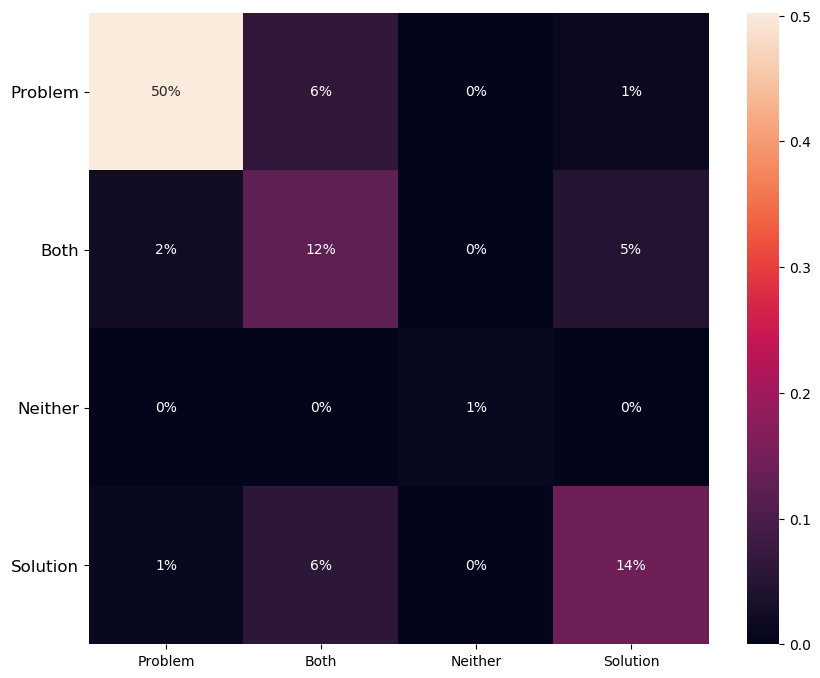

In [74]:
labels = y_test.values
index = columns = classNames2
cm_df = pd.DataFrame(mat/np.sum(mat),columns,index)                      
plt.figure(figsize=(10,8.2))  
sns.heatmap(cm_df, annot=True, fmt=".0%"
           )
plt.yticks(rotation=0, fontsize=12) 

## Saving and loading sklearn models

for more information check out this article: 
https://machinelearningmastery.com/save-load-machine-learning-models-python-scikit-learn/

In [ ]:
import pickle
# save the model to disk
filename = 'finalized_model.sav'
pickle.dump(model, open(filename, 'wb'))

In [ ]:
# loading the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.predict(X_test)
mat = get_performance(y_test.values, result, classNames2)

array(['yes', 'no', 'yes', ..., 'yes', 'yes', 'no'], dtype=object)

# Training the BERT base model with original data.

In [74]:
original_learner = train_learner(
       X_train, y_train.values, 
        X_val, y_val.values,
        lr= 1.5e-5, epoch=8, seed=1, text_length=512 , # parameters for the training
        checkpoint_folder="D:/models/transcript_models/"   # add the path where the checkpoints should be saved
    )

preprocessing train...


ValueError: texts must be a list or NumPy array

## After the training has finished, you will see the training statistics. I usually choose the epoch with the highest validation accuracy (if two performances were similar I chose the one with the lower validation loss).

If you used a checkpoint folder, you can load the model with the best performance rather than the last epoch. E.g. if you trained for 5 epochs, the default behaviour is that the model will use the last run, i.e. epoch 5. But if the performance of epoch 5 is worse than epoch 3, you can manually load the weights of epoch 3. See below:

In [26]:
original_learner[4].load_weights("D:/models/test/weights-06.hdf5")

learner_reloaded = ktrain.get_learner(original_learner[4], train_data=original_learner[2], val_data=original_learner[3], batch_size=2)

model_ = learner_reloaded
t_ = original_learner[1]
trn_ = original_learner[2]

# setting seeds (redundantly) before predicting validation set
set_seeds(seed)
# usually you only have to do this if you are interested in inter-class statistics of the valdiation set:D
## PREDICT ON VALIDATION SET
pred = predict_test(X_val.values, model_, 
                    t=t_,
                    trn=trn_)
predictor = pred[1]
val = t_.preprocess_test(X_val.values, y_val.values)
model_.validate(val_data= val )
mat = get_performance(y_val.values, pred[0], classNames2)

## PREDICT ON TEST SET
set_seeds(seed)
pred = predict_test(X_test.values, model_, 
                    t=t_,
                    trn=trn_)
predictor = pred[1]
test = t_.preprocess_test(X_test.values, y_test.values)
model_.validate(val_data= test , class_names = list(classNames2))
mat = get_performance(y_test.values, pred[0], classNames2)

preprocessing test...
language: en
test sequence lengths:
	mean : 324
	95percentile : 947
	99percentile : 1389


              precision    recall  f1-score   support

           0       0.88      0.97      0.92       316
           1       0.69      0.38      0.50        65

    accuracy                           0.87       381
   macro avg       0.79      0.67      0.71       381
weighted avg       0.85      0.87      0.85       381

; Prec:  0.7892512077294687 ; Rec:  0.6749026290165531 F1:  0.7089468402210872 ; Acc:  0.8661417322834646
[[305  11]
 [ 40  25]]
preprocessing test...
language: en
test sequence lengths:
	mean : 332
	95percentile : 959
	99percentile : 1522


              precision    recall  f1-score   support

         yes       0.88      0.97      0.92       394
          no       0.69      0.35      0.47        82

    accuracy                           0.86       476
   macro avg       0.78      0.66      0.69       476
weighted avg       0.85      0.86      0.84       476

; Prec:  0.7841781874039939 ; Rec:  0.6603318063637489 F1:  0.6940158952781673 ; Acc:  0.8613445378151261
[[381  13]
 [ 53  29]]


## Saving a ktrain model

If the test performance was good, and you want to save the actual model (not only the weights of the training) call **predictor.save( "yourPath")**.

In [27]:
# saving the ktrain model to disk ~500MB 
predictor.save("D:/models/models/"+variableCode)

In [ ]:
labels = y_test.values
index = columns = classNames2
cm_df = pd.DataFrame(mat/np.sum(mat),columns,index)                      
plt.figure(figsize=(10,8.2))  
sns.heatmap(cm_df, annot=True, fmt=".0%"
           )
plt.yticks(rotation=0, fontsize=12) 
plt.xlabel("Predicted class", fontsize=20)
plt.ylabel("Original class", fontsize=20)
plt.title("Confusion matrix test set, n=504", fontsize=25)

In [ ]:
#predictor.save("/home/lv71526/hbaginski/models/"+variableCode)

# Synthetic data generation with PPDB translations

# PPDB synonym lookup (get new df_train)
## this may take some time, for some reason, the initial loading of the model takes some time, the translations are rather quick one the model is loaded. The code does it automatically, it just may take some time to finsih

This functions basically does three things.
1. determine the majority class, get its frequency and ingore it.
2. iterate through all remaining classes and:
    use PPDB to replace aug_p words.
    repeat until the class frequency == majority class frequency.
   
The result is a perfectly balanced training dataset, i.e. all classes have the same number of observations. Above you can find the code how to sample from a saved csv file. (see section @Use this when you have a synthetic training set already and want to continue training with synthetic training set.)

In [26]:
# set augmentation probability
aug_p = 0.2

new_texts = []
new_classes = []
np.random.seed(1)
random.seed(1)
freq_origin = Counter(y_train.values)
majority_freq =  freq_origin.most_common()[0][1]
majority_class = freq_origin.most_common()[0][0]
seed = 1
# download model here:
    # http://nlpgrid.seas.upenn.edu/PPDB/eng/ppdb-2.0-tldr.gz
# and change the model path:
aug = naw.SynonymAug(aug_src='ppdb', model_path="D:\models\ppdb-2.0-tldr\ppdb-2.0-tldr",
                     aug_p=aug_p)
for i in tqdm(freq_origin.most_common()):
    df_tmp = filter_df(X_train, y_train.values, i[0])
    if i[0] == majority_class:
        print("getting base frequency")
    else:
        num_lang = ( (majority_freq-i[1]) /  i[1] )
        num_samples = num_lang * i[1]
        if num_samples < i[1]:
            AS = df_tmp["text"].sample(n=int(num_samples),  random_state=seed)
            TT = AS.values.tolist()
            for tweet in TT:
                augmented_text = aug.augment(tweet)
                new_texts.append(augmented_text)
                new_classes.append(i[0])
        else:
            for j in range(math.ceil(num_lang)):
                if num_samples < i[1]:
                    AS = df_tmp["text"].sample(n=int(num_samples),  random_state=seed)
                    TT = AS.values.tolist()
                    for tweet in TT:
                        augmented_text = aug.augment(tweet)
                        new_texts.append(augmented_text)
                        new_classes.append(i[0])
                else:
                    # translate entire set once
                    AS = df_tmp["text"]
                    TT = AS.values.tolist()
                    for tweet in TT:
                        augmented_text = aug.augment(tweet)
                        new_texts.append(augmented_text)
                        new_classes.append(i[0])
                    num_samples -= len(TT)        
    seed+=1
    print("done, first class", i[0])

  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

getting base frequency
done, first class Problem


 50%|██████████████████████████████████████████                                          | 2/4 [01:02<01:02, 31.02s/it]

done, first class Solution


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [02:07<00:41, 41.37s/it]

done, first class Both


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [03:47<00:00, 56.92s/it]

done, first class Neither


In [27]:
df_new = pd.DataFrame({
    "text": new_texts, 
    "class": new_classes
})

df_train = pd.DataFrame({
    "text": X_train, 
    "class":  y_train.values
})

df_train = df_train.append(df_new, ignore_index = True)

Counter(df_train["class"])

Counter({'Problem': 884, 'Both': 884, 'Neither': 884, 'Solution': 884})

## Saving the new df_train to disk to avoid retranslations

In [ ]:
#df_train.to_csv("MF01_balanced_ppdb60pc.csv", sep="\t")

#df_train = pd.read_csv("MF01_balanced_ppdb60pc.csv", sep="\t")

In [ ]:
Counter(df_train["class"].values)

In [ ]:
oversampled_learner2 = train_learner(
        df_train.text.values, df_train["class"].values,
        X_val, y_val.values,
        lr= 1.5e-5, epoch=1, seed=1, text_length=80 , # parameters for the training
        checkpoint_folder="D:/models/test/"   # add the path where the checkpoints should be saved
    )

In [ ]:
oversampled_learner2[0].validate(class_names = list(classNames2))

In [ ]:
set_seeds(seed)

pred = predict_test(X_test.values, oversampled_learner2[0], 
                    t=oversampled_learner2[1],
                    trn=oversampled_learner2[2])

predictor = pred[1]

test = oversampled_learner2[1].preprocess_test(X_test.values, y_test.values)
oversampled_learner2[0].validate(val_data= test , class_names = list(classNames2))

In [ ]:
mat = get_performance(y_test.values, pred[0], classNames2)
labels = y_test.values
capitalized = [i.capitalize() for i in classNames2]
index = columns = capitalized
cm_df = pd.DataFrame(mat/np.sum(mat),columns,index)                      
plt.figure(figsize=(10,8.2))  
sns.heatmap(cm_df, annot=True, fmt=".0%"
           )
plt.yticks(rotation=0, fontsize=12) 
plt.xlabel("Predicted class", fontsize=20)
plt.ylabel("Original class", fontsize=20)
plt.title("Confusion matrix test set, n=641", fontsize=25)

In [ ]:
# saving the predictor
predictor.save("/home/lv71526/hbaginski/models/"+variableCode)


In [ ]:
# loading predictor 
# loading model
reloaded_model = ktrain.load_predictor("/home/lv71526/hbaginski/models/"+variableCode)
new_pred = get_performance(y_test.values, reloaded_model.predict(X_test), classNames2)